# Time Series - IV (ARMA Models)

We have seen how Auroregressive (AR) and Moving average (MA) models explains the autocorrelation in data and we have also seen that not all of it can be explained by any one simple model. ARMA models or Autoregressive Moving average models are the combination of AR and MA models.

ARMA(p,z) is a combination of an AR model of order p and a MA model of order q. In the combination:
-  AR(p) model explains the momentum and the mean reversal effect of the market.
-  MA(q) model explains the shock effects observed.

ARMA(1,1) model looks like this:
\begin{align}
x_{t} = \alpha * x_{t-1} + \beta * e_{t-1} + e_{t}
\end{align}

where e(t) is white noise with mean = 0

In [9]:
# importing the necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import warnings
warnings.filterwarnings('ignore')

In [10]:
#Defining a function to visualize and analyze the time series 

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    '''
    Prepares a (3,2) dimensional plot for the visualization of time series values, autocorrelation and partial 
    autocorrelation plots and QQ and probability plots for comparision with normal distribution.
    
    Args:
    y: time series values
    lags: How many lagging values are to be considered.
    '''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)

        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

**Simulating an ARMA(2,2) model with alphas = [0.5, -0.25] and betas = [0.5, -0.3] **

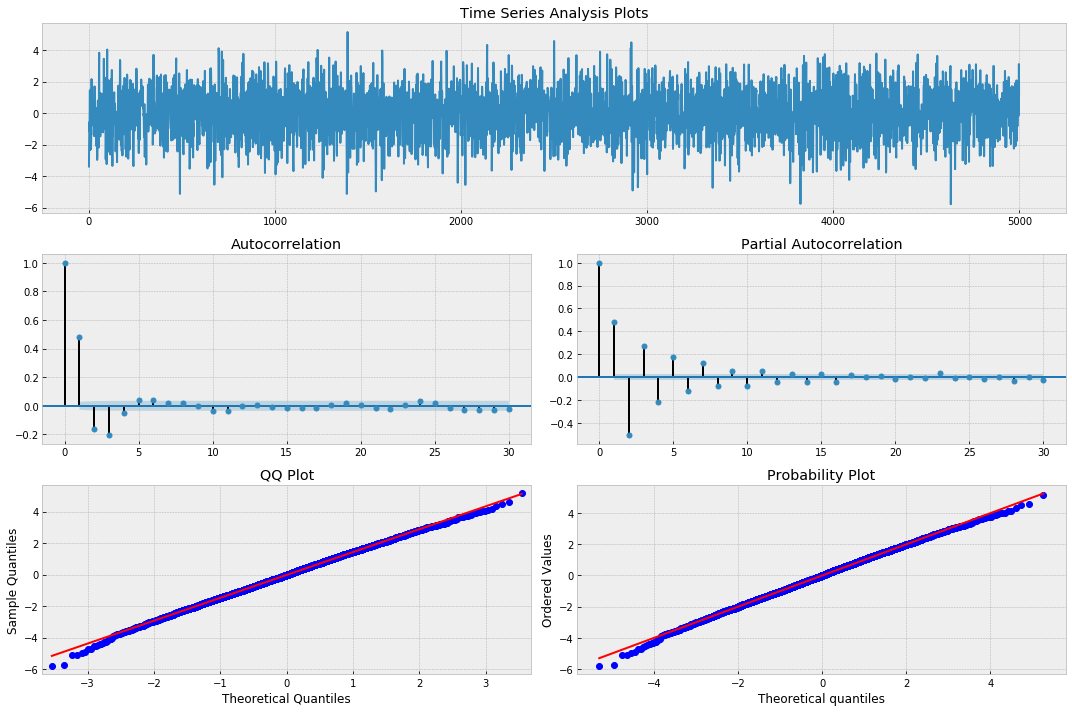

In [11]:
max_lag = 30
n = int(5000)
burn = int(n/10) #no of samples to disgard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar = ar, ma = ma, nsample = n, burnin = burn)
_ = tsplot(arma22, lags = max_lag)

Now that we have our ARMA(2,2) data, we will fit a model on this and see how well is our model able to estimate the alphas and betas.

In [12]:
model = smt.ARMA(arma22, order = (2,2)).fit( maxlag = max_lag,
                                           method = 'mle',
                                           trend = 'nc',
                                           burnin = burn)

print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7042.946
Method:                           mle   S.D. of innovations              0.990
Date:                Tue, 26 Jun 2018   AIC                          14095.892
Time:                        00:10:19   BIC                          14128.478
Sample:                             0   HQIC                         14107.312
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4555      0.053      8.521      0.000       0.351       0.560
ar.L2.y       -0.2699      0.015    -17.781      0.000      -0.300      -0.240
ma.L1.y        0.5684      0.055     10.355      0.0

**How do we decide the value of p and q to be choosen? **

We use AIC or Akaike Information Criteria to find the relative quality of a model on a given data. In the process, we fit multiple ARMA models or better ARMA models with multiple orders and then compare the values of the AIC. We finally select the model with minimum AIC value and perform Ljung-Box test if the model is a good fit or not.

**Ljung-Box test: ** This is a type of statistical test in which we try to reject the null hypothesis that the data into consideration is randomly distributed and exhibits no serial autocorrelation in the favor of Alternate hypothesis that there is serial correlation in the data/residuals. It is applied to the residuals of the fitted ARMA model and not to the original time series. Since the alternate hypothesis say that there are correlations in the residuals, this means it represents lack of fit of the model.


**Simulating an ARMA(3,2) model **

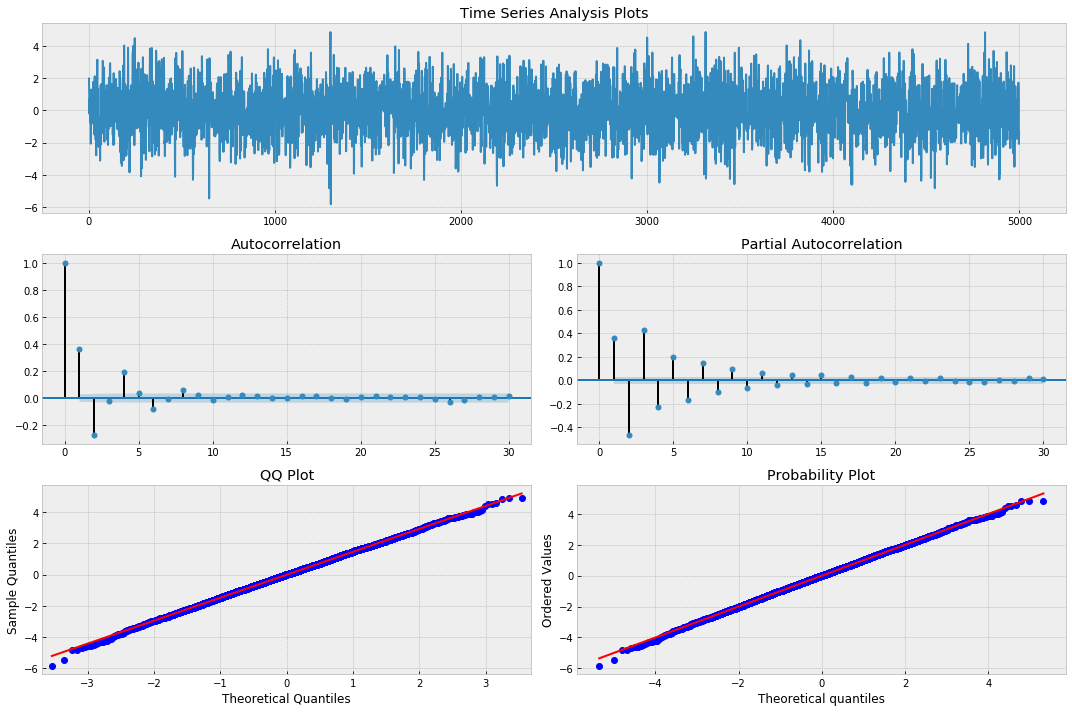

In [13]:
alphas = np.array([0.5, -0.4, 0.25])
betas = np.array([0.5, -0.3])

max_lag = 30
n = int(5000)
burn = 2000

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar = ar, ma = ma, nsample = n, burnin = burn)
_ = tsplot(arma32, lags = max_lag)

**Fitting the model and selecting the best AIC **

In [14]:
best_aic = np.inf
best_order = None
best_model = None

for i in range(5):
    for j in range(5):
        #print(i,j)
        try:
            tmp_model = smt.ARMA(arma32, order = (i,j)).fit(trend = 'nc',
                                                            method = 'mle')
            tmp_aic = tmp_model.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i,j)
                best_model = tmp_model
        except:
            continue

print('aic: %s, order: %s'%(best_aic, best_order))                                                            
        

aic: 14211.29997664779, order: (2, 4)


In [15]:
# Ljung-Box test

sms.diagnostic.acorr_ljungbox(best_model.resid, lags = [20], boxpierce=False)

(array([5.34614925]), array([0.99953549]))

Here the p-value obtained from Ljung-Box test is ~0.34, which is way higher than the general threshold of 0.05. Hence we reject the alternative hypothesis that there is serial correlation in the residuals and accept the null hypothesis that the residuals are independently distributed, indicating a good fit of the data in the model.

**Plotting the residuals: **

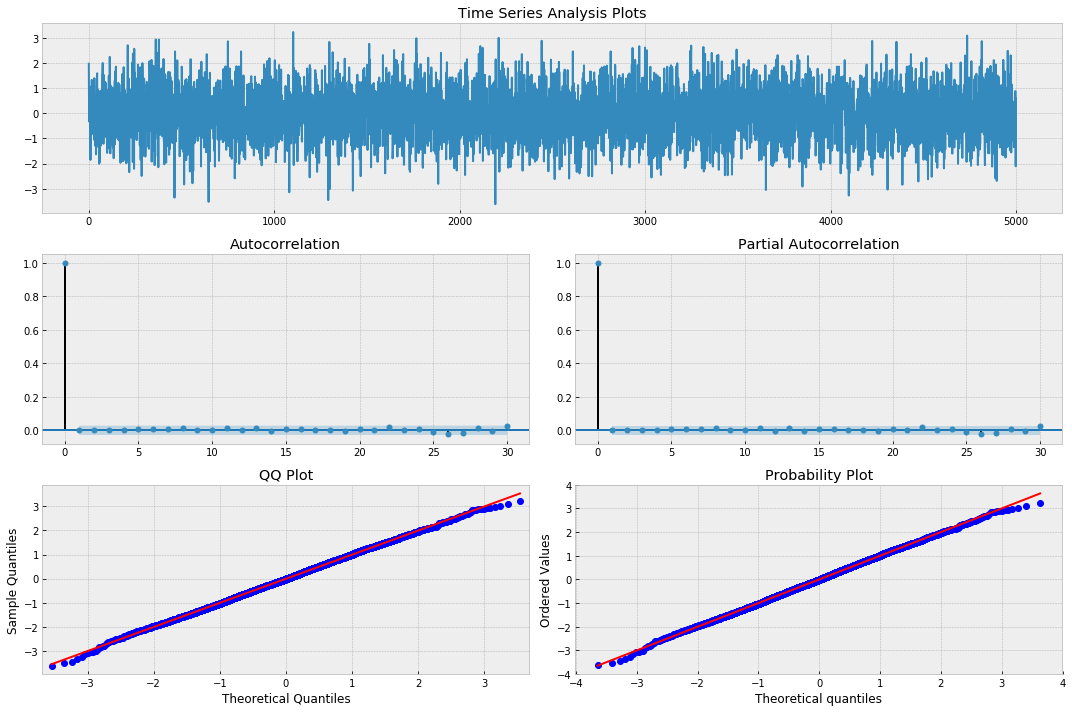

In [16]:
_ = tsplot(best_model.resid, lags=max_lag)